-   The provided code reads the coQA dataset related to questions and answers (Q&A), processes and analyzes the data using machine learning and natural language processing techniques
-   It includes steps for loading and manipulating data, utilizing pre-trained models for sequence classification, evaluating text similarity, and converting the processed data into different formats for further analysis and visualization.
-   Then it finally visualizes the data using the AutoViz library. 

In [ ]:
pip install transformers

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.4/7.4 MB 13.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 268.8/268.8 kB 28.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 37.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 39.0 MB/s eta 0:00:00


In [ ]:
pip install evaluate

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 81.4/81.4 kB 1.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 492.4/492.4 kB 16.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.3/115.3 kB 13.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 19.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 16.2 MB/s eta 0:00:00


In [ ]:
pip install rouge_score

  Preparing metadata (setup.py) ... done
  Created wheel for rouge_score: filename=rouge_score-0.1.2-py3-none-any.whl size=24933 sha256=36c5c4600104beaf1873ffe37fc455115ae59d7ce1a4176ba911638ac186f786
  Stored in directory: /root/.cache/pip/wheels/5f/dd/89/461065a73be61a532ff8599a28e9beef17985c9e9c31e541b4
Successfully built rouge_score


In [ ]:
import json

file_path = '/content/drive/MyDrive/NLP Proj/Coqa.json'

with open(file_path, 'r') as f:
    # Loading the coqa dataset (Dev version)
    data = json.load(f)

data.keys()

dict_keys(['version', 'data'])

In [ ]:
data = data['data']

In [ ]:
from transformers import AutoModelForSequenceClassification, AutoTokenizer

# Using Microsoft DeBERTa model for the generation of similaritic variablity
model_name = "microsoft/deberta-large-mnli"

tokenizer = AutoTokenizer.from_pretrained(model_name)

model = AutoModelForSequenceClassification.from_pretrained(model_name).cuda()

Some weights of the model checkpoint at microsoft/deberta-large-mnli were not used when initializing DebertaForSequenceClassification: ['config']
- This IS expected if you are initializing DebertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DebertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [ ]:
# Initializing an empty dictionary to hold the dataset
dataset = {
    'story': [],                    # To store the story text
    'question': [],                 # To store the questions related to the story
    'answer': [],                   # To store the answers to the questions
    'additional_answers': [],       # To store any additional answers
    'rouge1': [],                   # To store ROUGE-1 scores (a metric for text summarization)
    'rouge2': [],                   # To store ROUGE-2 scores
    'rougeL': [],                   # To store ROUGE-L scores
    'semantic_variability': [],     # To store measures of semantic variability
    'id': []                        # To store unique identifiers for each entry
}

In [ ]:
import evaluate

In [ ]:
# Using Rouge to evaluate syntactic similarity
rouge_metric = evaluate.load('rouge')

In [ ]:
import torch
import pandas as pd

In [ ]:
# Iterate through the data samples
for sample_index, sample in enumerate(data):
    story_text = sample['story']
    questions_list = sample['questions']
    answers_list = sample['answers']
    additional_answers_list = sample['additional_answers']
    
    # Iterating through the questions in each sample
    for question_id, question in enumerate(questions):
        question_text = question['input_text']
        answer_text = answers_list[question_id]['input_text']
        answer_start = answers_list[question_id]['span_start']
        
        # Appending data to the dataset
        dataset['story'].append(story_text)
        dataset['question'].append(question_text)
        dataset['answer'].append({'text': answer_text, 'answer_start': answer_start})
        dataset['id'].append(sample['id'] + '_' + str(question_id))

        additional_answers_for_question = [additional_answers_list[str(i)][question_id]['input_text'] for i in range(3)]
        dataset['additional_answers'].append(additional_answers_for_question)

        
        # Concatenating the story with the question and answer
        story_text += f' Q: {question_text} A: {answer_text}'
        if not story_text[-1] == '.':
            story_text += '.'
            
            
        all_answers = [answer_text] + additional_answers_for_question
        answer_pairs_1, answer_pairs_2 = [], []
        has_semantically_different_answers = False
        inputs = []
        
        # Computing syntactic similarity across reference answers
        for i, reference_answer in enumerate(all_answers):
            for j in range(4):
                if i != j:
                    answer_pairs_1.append(all_answers[i])
                    answer_pairs_2.append(all_answers[j])

                    input_text = question_text + ' ' + all_answers[i] + ' [SEP] ' + all_answers[j]
                    inputs.append(input_text)
                    

        # Encoding the inputs and making predictions
        encoded_input = tokenizer.batch_encode_plus(inputs, padding=True)
        prediction = model(torch.tensor(encoded_input['input_ids'], device='cuda'))['logits']
        predicted_label = torch.argmax(prediction, dim=1)
        if 0 in predicted_label:
            has_semantically_different_answers = True

        # Appending results to the dataset
        dataset['semantic_variability'].append(has_semantically_different_answers)
        results = rouge_metric.compute(predictions=answer_pairs_1, references=answer_pairs_2)
        dataset['rouge1'].append(results['rouge1'])
        dataset['rouge2'].append(results['rouge2'])
        dataset['rougeL'].append(results['rougeL'])

In [ ]:
print(dataset.keys())

dict_keys(['story', 'question', 'answer', 'additional_answers', 'rouge1', 'rouge2', 'rougeL', 'semantic_variability', 'id'])


In [ ]:
dataset_df = pd.DataFrame.from_dict(dataset)

In [ ]:
from datasets import Dataset

# Converting to HugagceFace Dataset Object and saving to disk
dataset = Dataset.from_pandas(dataset_df)
dataset.save_to_disk('/content/drive/MyDrive/NLP Proj/coqa_dataset')

Saving the dataset (0/1 shards):   0%|          | 0/7983 [00:00<?, ? examples/s]

In [ ]:
dataset_df.head()

story  \
0  Once upon a time, in a barn near a farm house,...   
1  Once upon a time, in a barn near a farm house,...   
2  Once upon a time, in a barn near a farm house,...   
3  Once upon a time, in a barn near a farm house,...   
4  Once upon a time, in a barn near a farm house,...   

                       question  \
0        What color was Cotton?   
1           Where did she live?   
2           Did she live alone?   
3        Who did she live with?   
4  What color were her sisters?   

                                              answer  \
0              {'text': 'white', 'answer_start': 59}   
1          {'text': 'in a barn', 'answer_start': 18}   
2                {'text': 'no', 'answer_start': 196}   
3  {'text': 'with her mommy and 5 sisters', 'answ...   
4  {'text': 'orange and white', 'answer_start': 428}   

                                  additional_answers    rouge1  rouge2  \
0                              [white, white, white]  1.000000     0.0   
1             [in a barn, in a barn, in a barn near]  0.928571     0.9   
2                                       [no, No, no]  1.000000     0.0   
3  [her mommy and 5 other sisters, her mommy and ...  0.916667     0.8   
4  [orange with white tiger stripes, orange, orange]  0.513889     0.0   

     rougeL  semantic_variability                                id  
0  1.000000                 False  3dr23u6we5exclen4th8uq9rb42tel_0  
1  0.928571                 False  3dr23u6we5exclen4th8uq9rb42tel_1  
2  1.000000                 False  3dr23u6we5exclen4th8uq9rb42tel_2  
3  0.916667                 False  3dr23u6we5exclen4th8uq9rb42tel_3  
4  0.527778                 False  3dr23u6we5exclen4th8uq9rb42tel_4

In [ ]:
from google.colab import files
dataset_df.to_csv('coqa.csv', index=False)
files.download('coqa.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
pip install autoviz

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 67.0/67.0 kB 8.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 356.6/356.6 kB 37.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.3/4.3 MB 88.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 104.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 61.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 88.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 121.9/121.9 kB 16.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.9/84.9 kB 10.9 MB/s eta 0:00:00
  Created wheel for emoji: filename=emoji-2.6.0-py2.py3-none-any.whl size=351311 sha256=8d93a21639802c9fcfa0c61e971f688be861959f8c15d7bd2493a22639345ee3
  Stored in directory: /root/.cache/pip/wheels/ea/0b/64/114bc939d0083621aa41521e21be246c888260b8aa21e6c1ad
Successfully built emoji
  Attempting uninstall: holoviews


Imported v0.1.730. After importing autoviz, execute '%matplotlib inline' to display charts inline.
    AV = AutoViz_Class()
    dfte = AV.AutoViz(filename, sep=',', depVar='', dfte=None, header=0, verbose=1, lowess=False,
               chart_format='svg',max_rows_analyzed=150000,max_cols_analyzed=30, save_plot_dir=None)
Shape of your Data Set loaded: (7983, 9)
#######################################################################################
######################## C L A S S I F Y I N G  V A R I A B L E S  ####################
#######################################################################################
Classifying variables in data set...
    9 Predictors classified...
        1 variable(s) removed since they were ID or low-information variables
        List of variables removed: ['id']
To fix data quality issues automatically, import FixDQ from autoviz...


Number of All Scatter Plots = 6


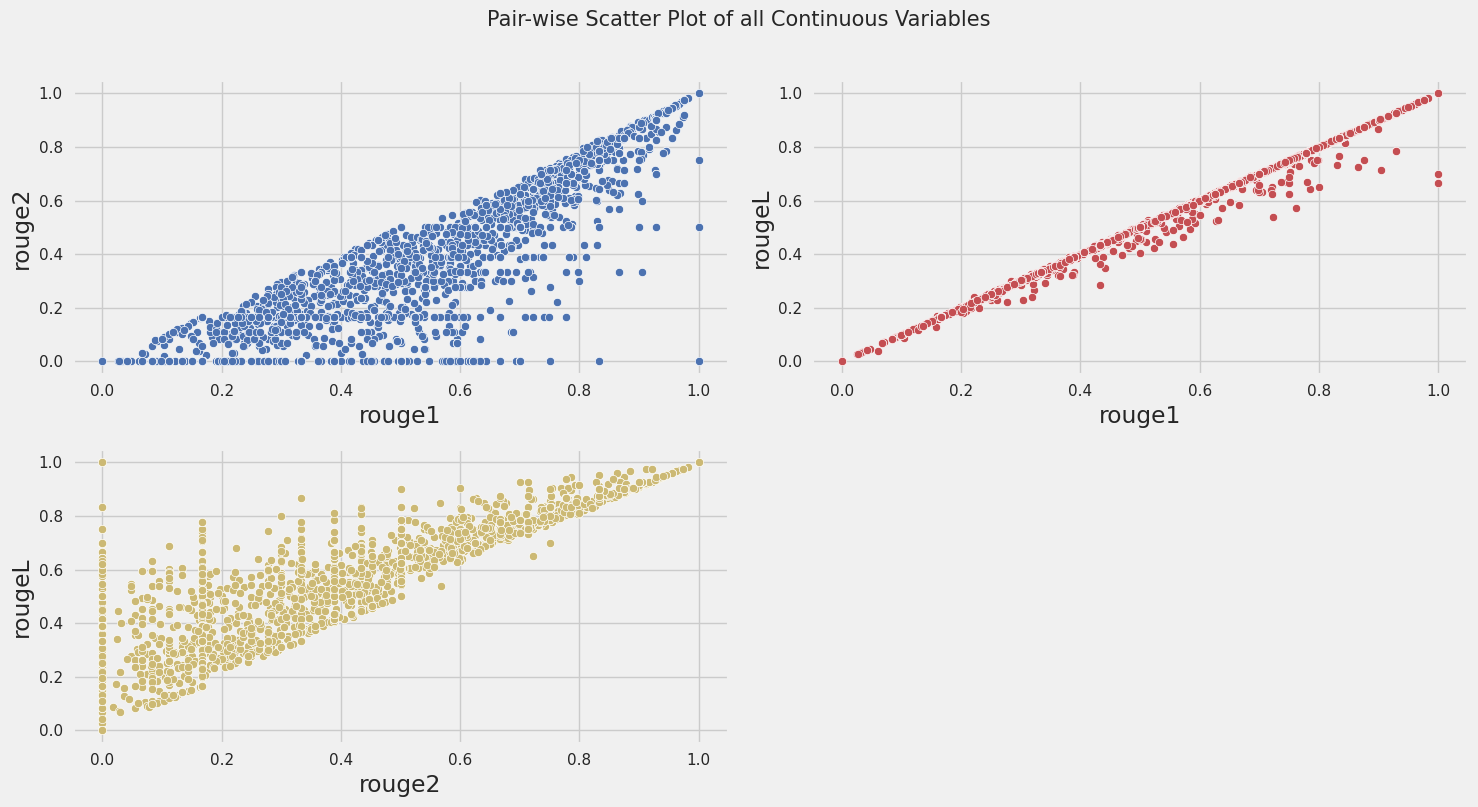

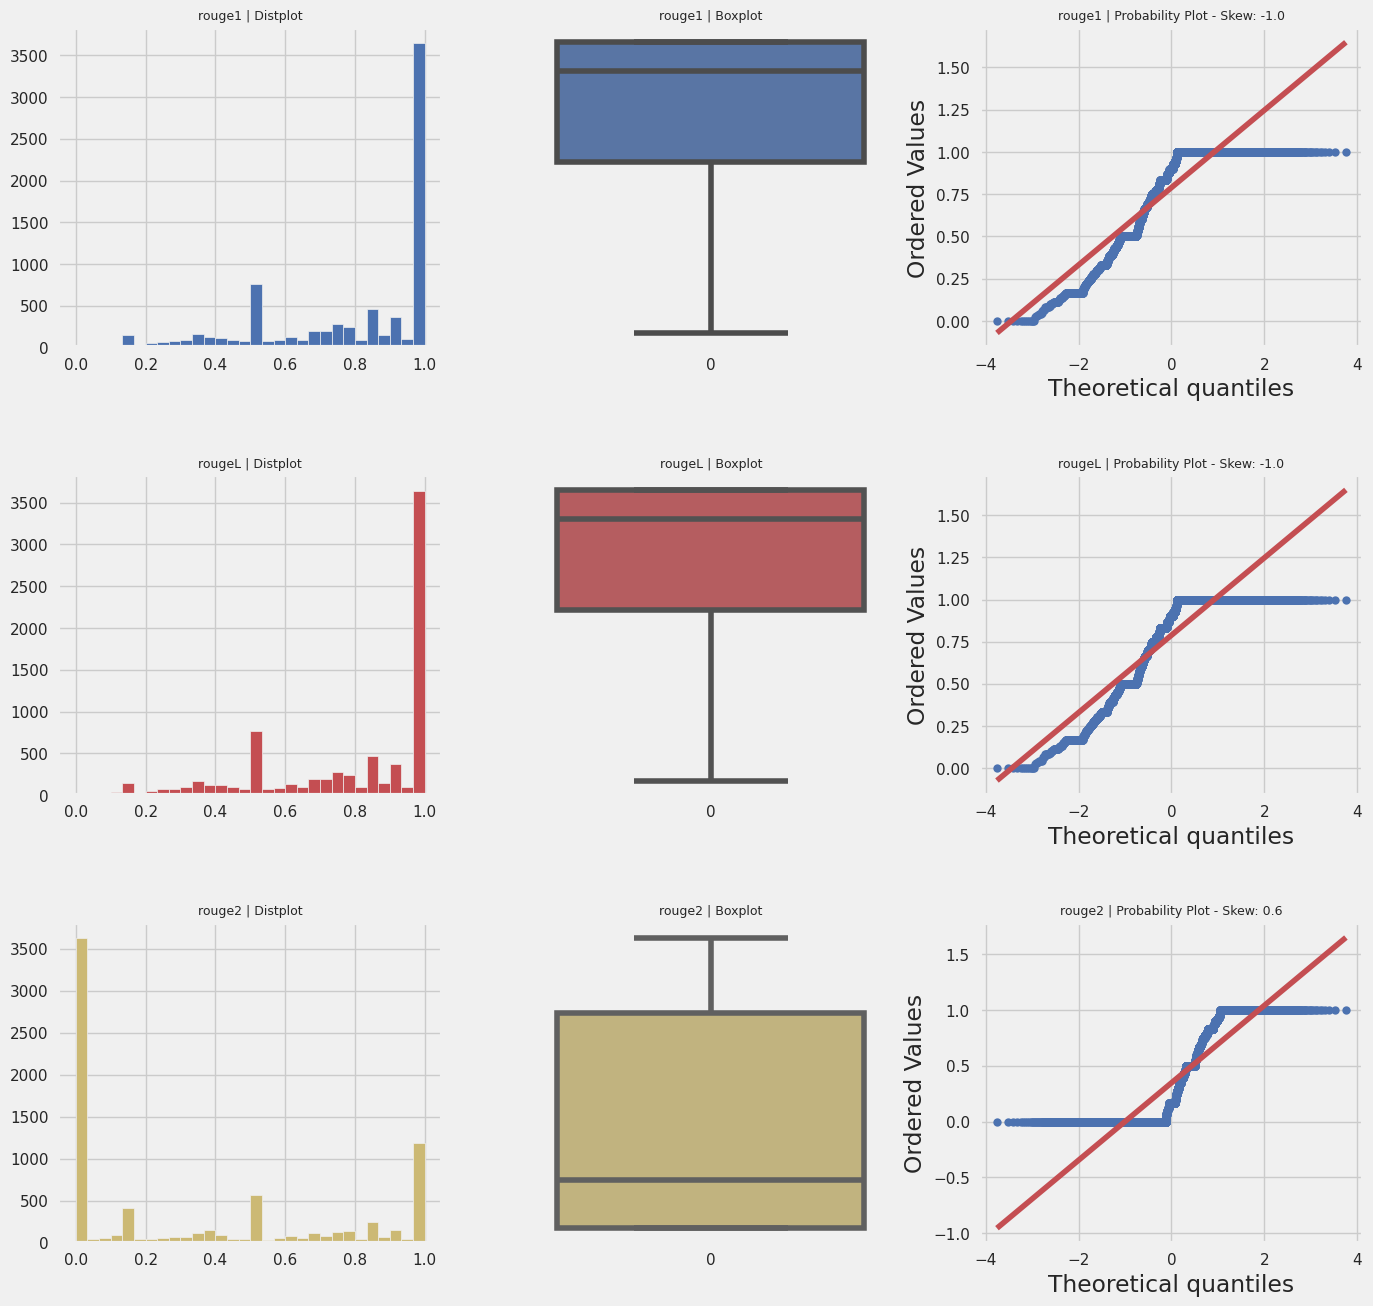

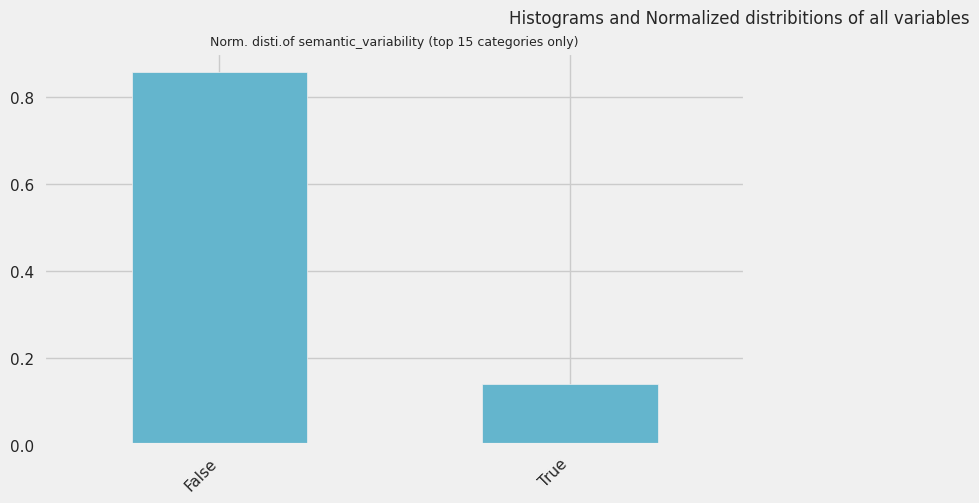

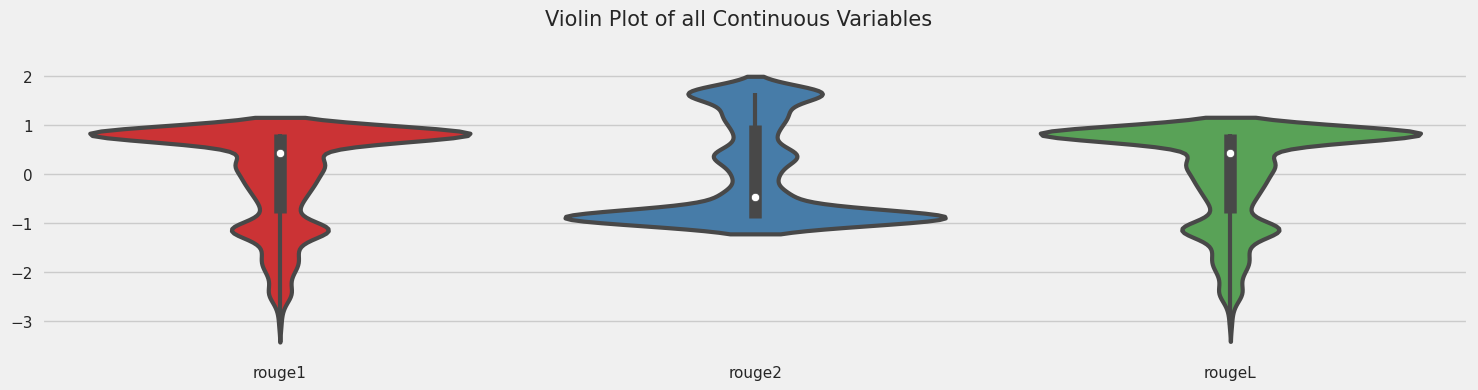

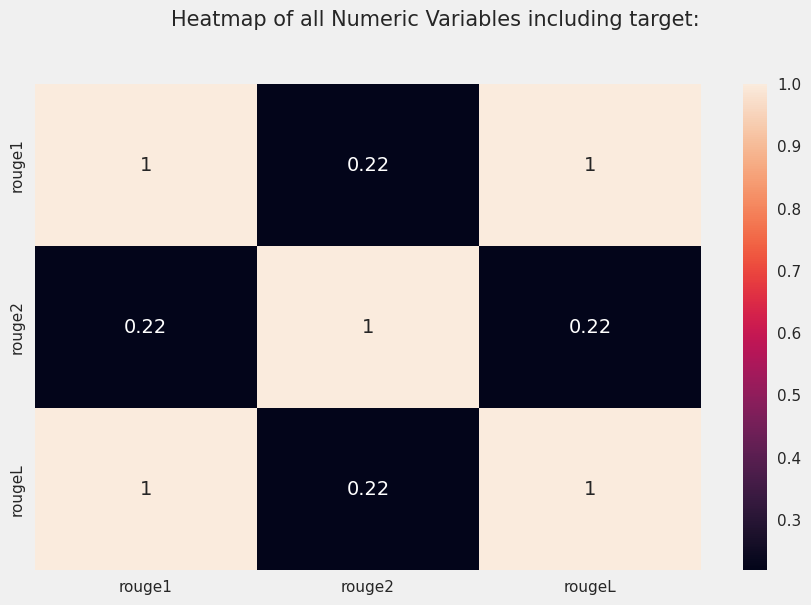

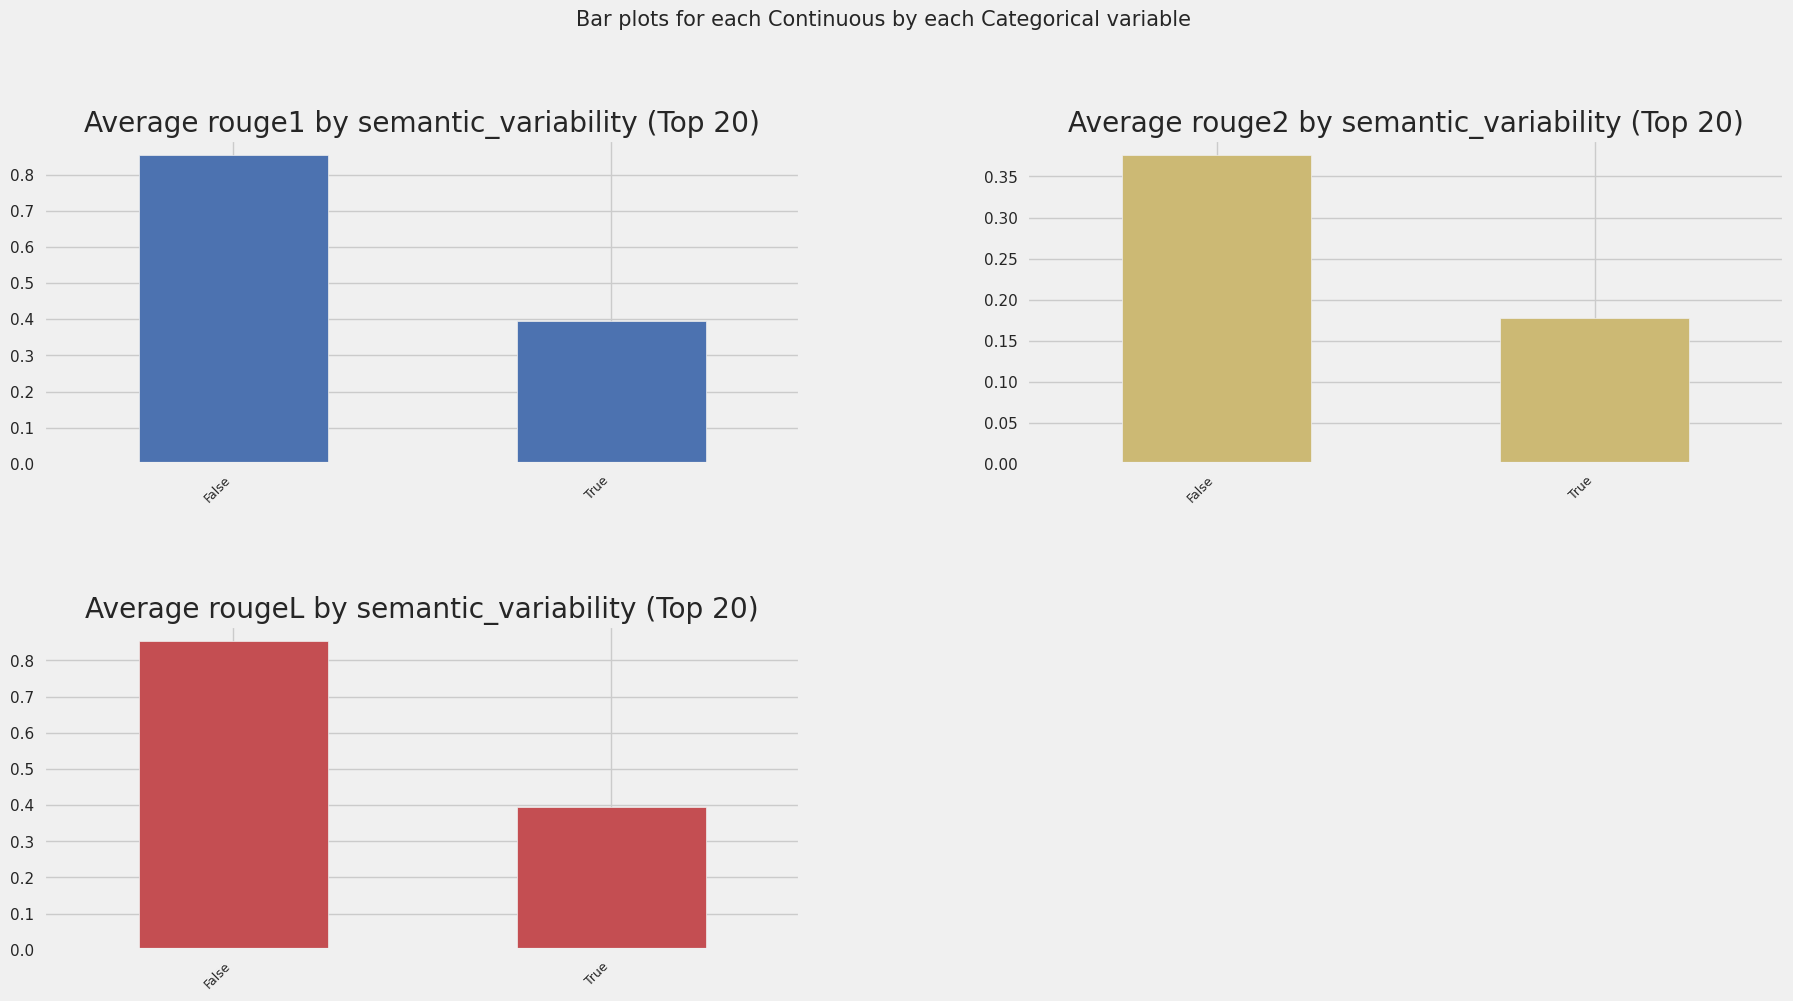

[nltk_data] Downloading collection 'popular'
[nltk_data]    | 
[nltk_data]    | Downloading package cmudict to /root/nltk_data...
[nltk_data]    |   Unzipping corpora/cmudict.zip.
[nltk_data]    | Downloading package gazetteers to /root/nltk_data...
[nltk_data]    |   Unzipping corpora/gazetteers.zip.
[nltk_data]    | Downloading package genesis to /root/nltk_data...
[nltk_data]    |   Unzipping corpora/genesis.zip.
[nltk_data]    | Downloading package gutenberg to /root/nltk_data...
[nltk_data]    |   Unzipping corpora/gutenberg.zip.
[nltk_data]    | Downloading package inaugural to /root/nltk_data...
[nltk_data]    |   Unzipping corpora/inaugural.zip.
[nltk_data]    | Downloading package movie_reviews to
[nltk_data]    |     /root/nltk_data...
[nltk_data]    |   Unzipping corpora/movie_reviews.zip.
[nltk_data]    | Downloading package names to /root/nltk_data...
[nltk_data]    |   Unzipping corpora/names.zip.
[nltk_data]    | Downloading package shakespeare to /root/nltk_data...
[nlt

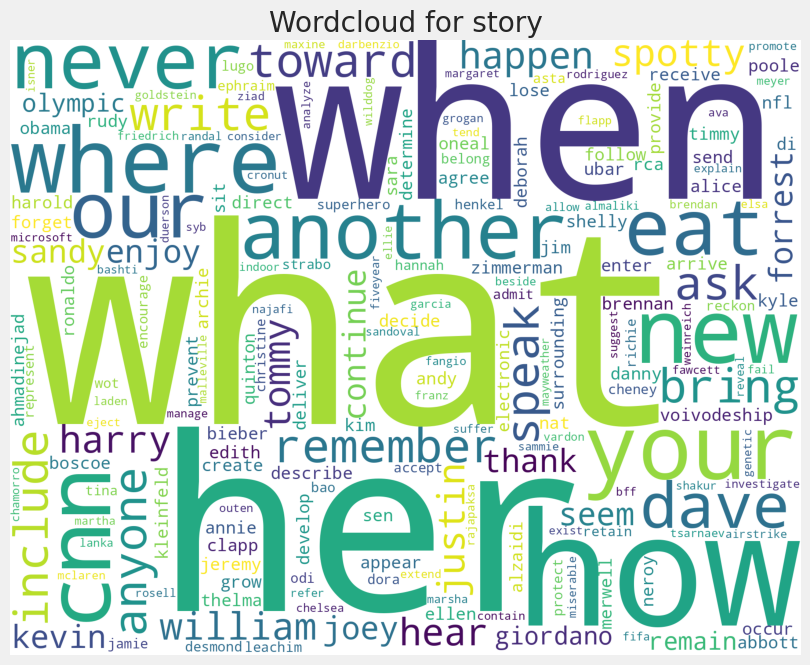

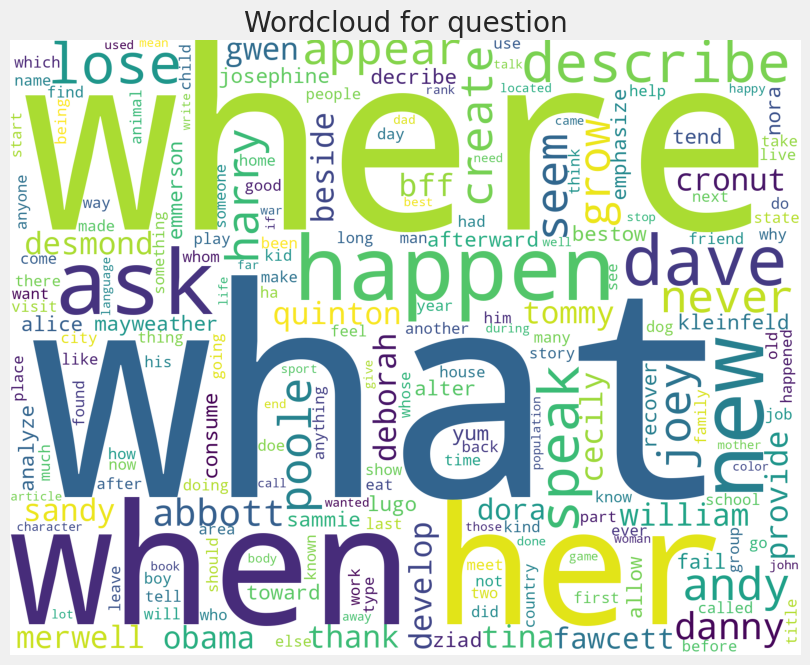

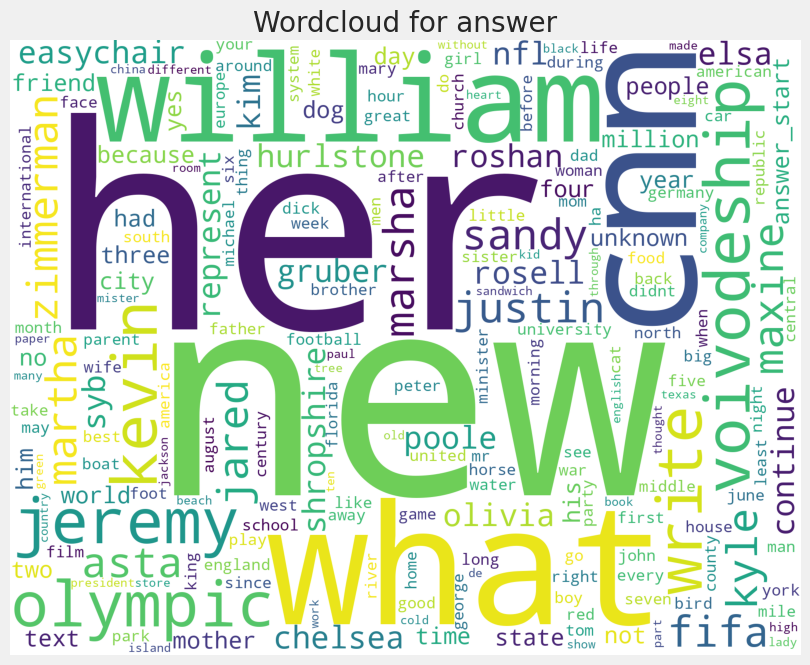

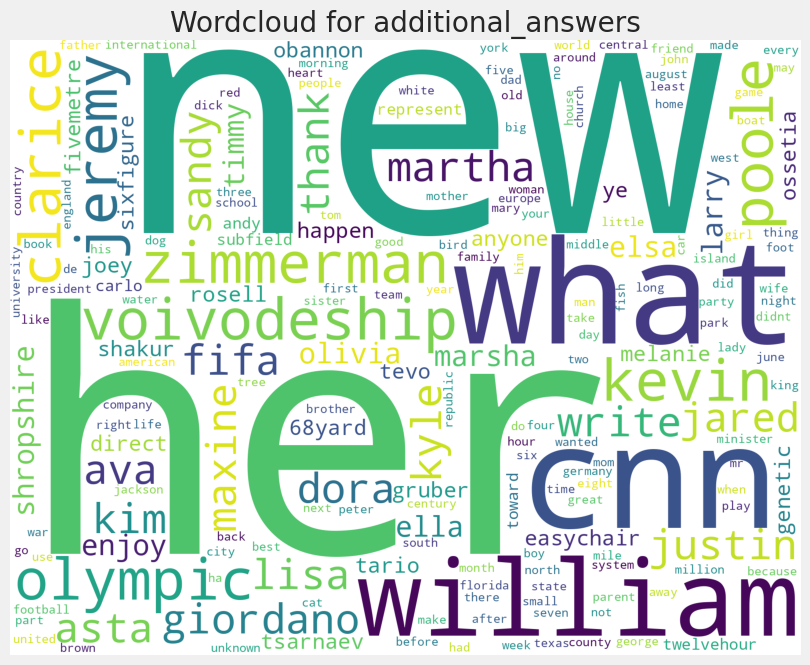

All Plots done
Time to run AutoViz = 67 seconds 

 ###################### AUTO VISUALIZATION Completed ########################


In [ ]:
from autoviz.AutoViz_Class import AutoViz_Class

%matplotlib inline

# Use AutoViz_Class to visualize the data with all possible combinations
AV = AutoViz_Class()

viz = AV.AutoViz("coqa.csv", sep=',')